In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, re
import time
random.seed(time.clock())

/Users/jinli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
#read tsp data file

def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX,coordY])
        cities = pd.DataFrame(cities_coord)
        return dimension, cities

In [3]:
#Create two classes: City and Fitness
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [4]:
#Running the genetic algorithm
#First, we need to get the cities
filename='/Users/jinli/qa194.tsp'
nb_cities, cities_coord = read_tsplib_file(filename)
print(cities_coord)


              0           1
0    24748.3333  50840.0000
1    24758.8889  51211.9444
2    24827.2222  51394.7222
3    24904.4444  51175.0000
4    24996.1111  51548.8889
..          ...         ...
189  26123.6111  51169.1667
190  26123.6111  51222.7778
191  26133.3333  51216.6667
192  26133.3333  51300.0000
193  26150.2778  51108.0556

[194 rows x 2 columns]


In [5]:

city_list = []
for i in range(0,nb_cities):
    city_list.append(City(x=cities_coord.loc[i,0], y=cities_coord.loc[i,1]))
    
print(city_list)  
#type(cityList)

[(24748.3333,50840.0), (24758.8889,51211.9444), (24827.2222,51394.7222), (24904.4444,51175.0), (24996.1111,51548.8889), (25010.0,51039.4444), (25030.8333,51275.2778), (25067.7778,51077.5), (25100.0,51516.6667), (25103.3333,51521.6667), (25121.9444,51218.3333), (25150.8333,51537.7778), (25158.3333,51163.6111), (25162.2222,51220.8333), (25167.7778,51606.9444), (25168.8889,51086.3889), (25173.8889,51269.4444), (25210.8333,51394.1667), (25211.3889,51619.1667), (25214.1667,50807.2222), (25214.4444,51378.8889), (25223.3333,51451.6667), (25224.1667,51174.4444), (25233.3333,51333.3333), (25234.1667,51203.0556), (25235.5556,51330.0), (25235.5556,51495.5556), (25242.7778,51428.8889), (25243.0556,51452.5), (25252.5,51559.1667), (25253.8889,51535.2778), (25253.8889,51549.7222), (25256.9444,51398.8889), (25263.6111,51516.3889), (25265.8333,51545.2778), (25266.6667,50969.1667), (25266.6667,51483.3333), (25270.5556,51532.7778), (25270.8333,51505.8333), (25270.8333,51523.0556), (25275.8333,51533.6111)

### The preselection of population

In [6]:
def fitness(route):
    distance = 0
    for i in range(len(route)):
        distance += city_list[route[i-1]].distance(city_list[route[i]])
    return distance

random.seed(30)

def mutate(dad, rate):
    permute = []
    permute = [[np.random.randint(len(city_list)), np.random.randint(len(city_list))] for i in range(rate)]
    route = [dad[i] for i in range(len(dad))]
    for i in range(rate):
        temp = route[permute[i][0]]
        route[permute[i][0]] = route[permute[i][1]]
        route[permute[i][1]] = temp
    return route

def rotate(l, n):
    return l[-n:] + l[:-n]

#This crossover uses 3 parents, A and B provide the "genes", C is used to determine the shape
#The idea is, that you want to keep parts that are close together close together, and just find a more efficient way to connect the points in this part
def crossover(A,B,C):
    temp = rotate(C,np.random.randint(0,len(C)+1))
    C1 = temp[:int(len(C)/2)]
    C2 = temp[int(len(C)/2):]
    ret = []
    for a in A:
        if a in C1:
            ret.append(a)
    for b in B:
        if b in C2:
            ret.append(b)
    return ret

In [7]:
#Intersection of two lines defined by two pair of points (A,B) and (C,D). Used for the resolving of crossings
def intersect(A,B,C,D):
    if D[0] == C[0] and B[0] == A[0]:
        return False
    if B[0] == A[0]:
        M2 = (D[1] - C[1])*1.0/(D[0] - C[0])
        C2 = C[1]-(M2*C[0])
        X0 = B[0]
        return [X0, M2*X0 +C2]
    if D[0] == C[0]:
        M1 = (B[1] - A[1])*1.0/(B[0] - A[0])
        C1 = A[1]-(M1*A[0])
        X0 = B[0]
        return [X0, M1*X0 +C1]
    
    M1 = (B[1] - A[1])*1.0/(B[0] - A[0])
    M2 = (D[1] - C[1])*1.0/(D[0] - C[0])
    
    C1 = A[1]-(M1*A[0])
    C2 = C[1]-(M2*C[0])
    
    if M1 == M2:
        return False
    
    else:
        X0 = (C1 - C2)/(M2 - M1)
        return [X0, M2*X0 +C2]

#This function checks (in the most naive way) if the intersection will given an intersection in the graph    
def check_intersect(A,B,C,D):
    E = intersect(A,B,C,D)
    FX_Max = max(A[0],B[0])
    FX_Min = min(A[0],B[0])
    GX_Max = max(C[0],D[0])
    GX_Min = min(C[0],D[0])
    
    FY_Max = max(A[1],B[1])
    FY_Min = min(A[1],B[1])
    GY_Max = max(C[1],D[1])
    GY_Min = min(C[1],D[1])
    
    if E == False:
        return False
    if E[0] >= FX_Max:
        return False
    if E[0] <= FX_Min:
        return False
    if E[0] >= GX_Max:
        return False
    if E[0] <= GX_Min:
        return False
    
    if E[1] >= FY_Max:
        return False
    if E[1] <= FY_Min:
        return False
    if E[1] >= GY_Max:
        return False
    if E[1] <= GY_Min:
        return False
    else:
        return True

In [8]:
#Graph class, used for drawing the map and making the initial guess
class graph:
    def __init__(self, vertices, edges):
        self.edges = edges
        self.vertices = vertices
    def draw_map(self):
        plt.figure(figsize=(8,8))
        for e in self.edges:
            plt.plot([city_list[e[0]].x, city_list[e[1]].x], [city_list[e[0]].y, city_list[e[1]].y] , linestyle='-', color = 'turquoise')
        for v in self.vertices:
            plt.scatter(city_list[v].x,city_list[v].y, color='red')
            plt.text(city_list[v].x-20, city_list[v].y+40, str(v), fontsize=10)
        plt.axis('scaled')
        plt.show()
    #This function is used in the create_route methode down below
    def connected_components(self):
        comps = [{a} for a in self.vertices]
        for e in self.edges:
            inside = -1
            i = 0
            while i < len(comps):
                if inside >= 0:
                    if e[0] in comps[i] or e[1] in comps[i]:
                        comps[i].add(e[1])
                        comps[i].add(e[0])
                        for a in comps[i]:
                            comps[inside].add(a)
                        comps.pop(i)
                    else:
                        i+=1
                else:
                    if e[0] in comps[i] or e[1] in comps[i]:
                        comps[i].add(e[1])
                        inside = i
                    i += 1
        return comps
    
    def edges_at_v(self,vertex):
        ret = []
        for e in self.edges:
            if vertex == e[0]:
                ret.append(e[1])
            elif vertex == e[1]:
                ret.append(e[0])
        return ret
    
    
    def create_route(self):
        if self.connected_components() == 1:
            connected = True
        else:
            connected = False
        check = [i for i in range(1,len(city_list))]
        cur = 0
        skip = False
        route = [0]
        while check != []:
            skip = False
            temp = self.edges_at_v(cur)
            cand = [temp[i] for i in range(len(temp))]
            offset = 0
            for j in range(len(cand)):
                if cand[j - offset] not in check:
                    cand.pop(j - offset)
                    offset += 1
            #The results might be better if you choose an epsilon that gives a connected graph (the lowest so might be the best)
            #To avoid that you might want to change this function
            if cand == []:
                if connected:
                    skip = True
                    cand = [temp[i] for i in range(len(temp))]
                else:
                    cand = [np.random.choice(check)]
                    
            upcoming = random.choice(cand)
            cur = upcoming
            if skip == False:
                route.append(cur)
                check.pop(check.index(cur))
        return route

In [9]:
#This function resolves (more or less) the crossings in a path by "twisting" loops (imagine you want to turn "8" to "O" by twisting a String).
def resolve(ls, cut = 10):
    test2 = [ls[i] for i in range(len(ls))]
    y = 0
    z = 0
    while y < 2 and z < cut:
        for i in range(-1,len(test2)-3):
            for j in range(i + 2, len(test2)-1):
                if check_intersect([city_list[test2[i]].x, city_list[test2[i]].y], [city_list[test2[i+1]].x, city_list[test2[i+1]].y], [city_list[test2[j]].x, city_list[test2[j]].y], [city_list[test2[j+1]].x, city_list[test2[j+1]].y]):
                    temp = [test2[i] for i in range(i+1,j+1)]
                    for k in range(1,len(temp)+1):
                        test2[i+k] = temp[-k]
                    i = -1
                    j = 1
                    y = 0
        y += 1
        z += 1
    return test2

In [10]:
#Defines a graph that connects point with length under a certain treshold, this allows us to make a locally reasonable good guess
#One could improve by automatically determine a reasonable epsilon from the scale of the map and the number of points
epsilon = 100
e = []
v = []
for i in range(len(city_list)):
    v.append(i)
    for j in range(i+1, len(city_list)):
        if city_list[i].distance(city_list[j]) < epsilon:
            e.append([i,j])
city_map = graph(v,e)

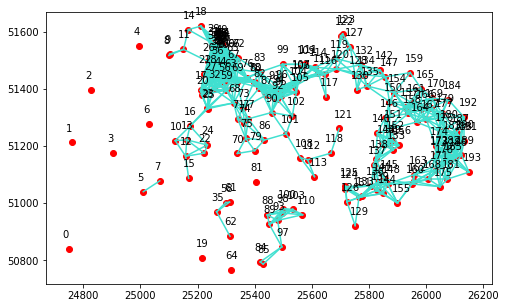

In [11]:
#Play around with the epsilon variable in the box above and see what happens
city_map.draw_map()

In [12]:
#That's a testbox, to see what initial path you can get
e = []
v = []
test = city_map.create_route()
for i in range(len(test)):
    e.append([test[i-1], test[i]])
    v.append(i)
city_map2 = graph(v,e)

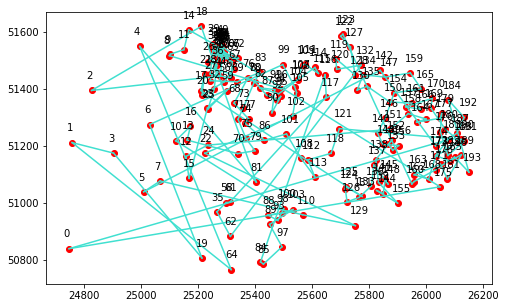

In [13]:
#It looks like that
city_map2.draw_map()

In [14]:
#Now resolve the Path
e = []
v = []
test = resolve(test)
for i in range(len(city_list)):
    e.append([test[i-1], test[i]])
    v.append(i)
city_map2 = graph(v,e)

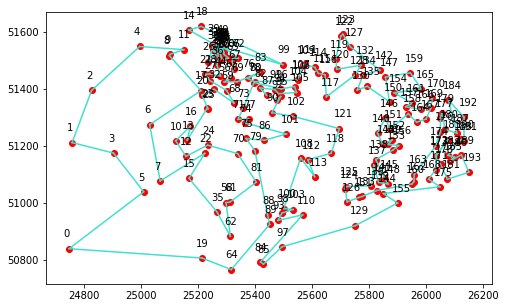

In [15]:
#Looks pretty good already ;)
city_map2.draw_map()

### This is the actual genetic Algorithm
Because I was lazy it isn't even a function...

In [16]:
#Make Initial guesses by using the graph defined by epsilon and resolving the route created by the graph class
population2 = [resolve(city_map.create_route()) for i in range(10)]

#mutation parameters, you can play around with that but you need to change the indices in the "MUTATION" part
weight = [1,1,1,1,2,2,3,5,10]
max_gen = 300
candidate = []
best_score = []
for t in range(max_gen):
    candidate = [population2[i] for i in range(len(population2))]
    for j in range(len(population2)):
        #CROSSOVER
        for k in range(5):
           
            ls = [population2[j][i] for i in range(len(population2[j]))]
            new = crossover(random.choice(population2), random.choice(population2),population2[j])
            candidate.append(new)
        #MUTATION
        for l in range(5):
            ls = [population2[j][i] for i in range(len(population2[j]))]
            p1 = mutate(random.choice(population2),weight[l])
            p2 = mutate(random.choice(population2),weight[l+4])
            new2 =crossover(p1, p2,population2[j])
            candidate.append(p1)
            candidate.append(p2)
            candidate.append(new2)
            
    score = np.array([fitness(candidate[i]) for i in range(len(candidate))])
    population2 = [candidate[i] for i in score.argsort()[:int(10*(np.log(1+t)+1))]]
    for i in range(3):
        population2.append(resolve(city_map.create_route()))
    best_score.append(score[score.argsort()[0]])
    
    #Here some output, to make sure the code is actually doing something and your notebook didn't die already
    if t%1 == 0:
        #population2 = [resolve(population2[i]) for i in range(len(population2))]
        print(t, best_score[t], len(population2))
        
    #Resolve the whole population after 50 generations
    #This is a compromise between best results (always resolving) and decent runtime
    if t%50 == 0:
        population2 = [resolve(population2[i], 50) for i in range(len(population2))]
    
population2 = [resolve(population2[i], 50) for i in range(len(population2))]
print(population2[0], fitness(population2[0]))

0 13967.700411915097 13
1 13590.972871993552 19
2 13590.972871993552 23
3 13590.972871993552 26
4 13590.972871993552 29
5 13590.972871993552 30
6 13590.972871993552 32
7 13532.848967199474 33
8 13532.848967199474 34
9 13532.848967199474 36
10 13532.848967199474 36
11 13414.51829846128 37
12 13414.51829846128 38
13 13414.51829846128 39
14 13414.51829846128 40
15 13414.51829846128 40
16 13036.79060740043 41
17 13036.79060740043 41
18 13036.79060740043 42
19 13036.79060740043 42
20 13036.79060740043 43
21 13036.79060740043 43
22 13036.79060740043 44
23 13036.79060740043 44
24 13036.79060740043 45
25 13036.79060740043 45
26 13036.79060740043 45
27 13036.79060740043 46
28 13036.79060740043 46
29 12978.471636237378 47
30 12772.126280762031 47
31 12772.126280762031 47
32 12772.126280762031 47
33 12772.126280762031 48
34 12758.488483049812 48
35 12707.426035972356 48
36 12642.520696681464 49
37 12534.127740217476 49
38 12534.127740217476 49
39 12534.127740217476 49
40 12522.723930951022 50
41 

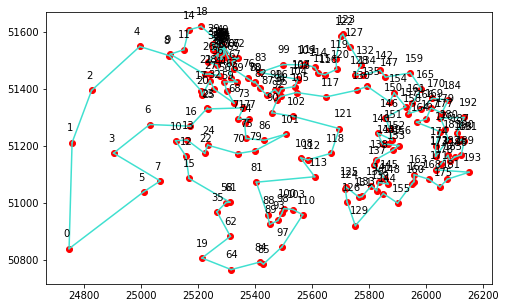

In [17]:
#Draw your best route
e = []
v = []
test = candidate[score.argsort()[0]]
for i in range(len(test)):
    e.append([test[i-1], test[i]])
    v.append(i)
city_map_2 = graph(v,e)
city_map_2.draw_map()

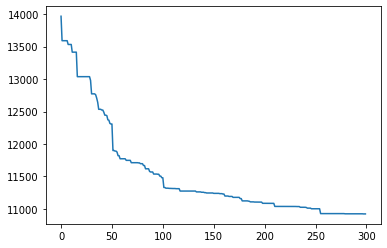

In [18]:
#And the fitness graph
plt.plot(best_score)